In [1]:
import numpy as np
import pandas as pd

import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
num_classes = 6

In [5]:
train_val_data = pd.read_csv('/kaggle/input/ukraine-ml-bootcamp-2023/train.csv')

The *image_id* column contains image file names, whereas the *class_6* column contains respective labels.

In [26]:
train_val_data.head()

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0


In [6]:
train_val_images = np.array(os.listdir('/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images'))

In [7]:
train_val_labels = []
for path in train_val_images:
    train_val_labels.append(
        train_val_data.loc[train_val_data['image_id'] == path, 'class_6'].values[0]
    )
train_val_labels = np.array(train_val_labels, dtype=str)

In [8]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=42)

In [9]:
target_height = 400
target_width = 400

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_images, 'label': train_labels}),
    directory='/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images',
    x_col='filename',
    y_col='label',
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_images, 'label': val_labels}),
    directory='/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images',
    x_col='filename',
    y_col='label',
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical'
)

Found 1888 validated image filenames belonging to 6 classes.
Found 472 validated image filenames belonging to 6 classes.


In [12]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [13]:
# Loading Xception with pretrained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(target_height, target_width, 3))

# Adding custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)  # Adding dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Adding L2 regularization
predictions = Dense(num_classes, activation='softmax')(x)

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 [==============================] - 0s 0us/step


In [14]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Scheduling the learning rate
def lr_scheduler(epoch):
    return 0.0001 * 0.95 ** epoch

lr_schedule = LearningRateScheduler(lr_scheduler)

In [16]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/model.keras',  # Path to save the best model weights
    monitor='val_accuracy',     # Metric to monitor for improvement
    save_best_only=True,        # Saving only the best model
    save_weights_only=False,    # Saving entire model, including architecture
    mode='max',                 # Mode for comparison, 'max' for accuracy
    verbose=1
)

In [25]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, 
               lr_schedule,
               checkpoint]
)

Epoch 1/25
118/118 [==============================] - ETA: 0s - loss: 5.7688 - accuracy: 0.3877
Epoch 1: val_accuracy improved from -inf to 0.60593, saving model to /kaggle/working/model.keras
118/118 [==============================] - 147s 1s/step - loss: 5.7688 - accuracy: 0.3877 - val_loss: 4.9334 - val_accuracy: 0.6059 - lr: 1.0000e-04
Epoch 2/25
118/118 [==============================] - ETA: 0s - loss: 4.5798 - accuracy: 0.6790
Epoch 2: val_accuracy improved from 0.60593 to 0.79025, saving model to /kaggle/working/model.keras
118/118 [==============================] - 115s 972ms/step - loss: 4.5798 - accuracy: 0.6790 - val_loss: 4.0347 - val_accuracy: 0.7903 - lr: 9.5000e-05
Epoch 3/25
118/118 [==============================] - ETA: 0s - loss: 3.8042 - accuracy: 0.7871
Epoch 3: val_accuracy improved from 0.79025 to 0.80508, saving model to /kaggle/working/model.keras
118/118 [==============================] - 117s 986ms/step - loss: 3.8042 - accuracy: 0.7871 - val_loss: 3.4956 - 

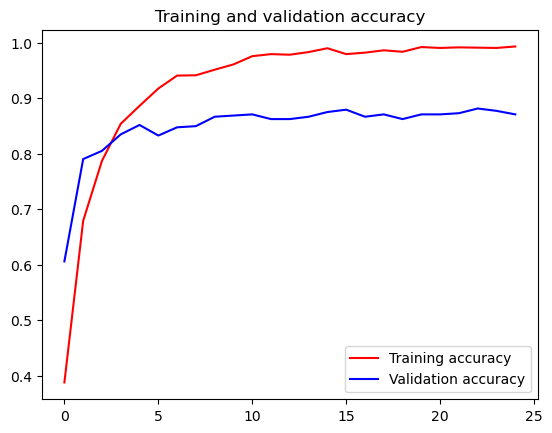

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt

# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [20]:
model.save('/kaggle/working/model.keras')

In [17]:
from tensorflow.keras.models import load_model

In [18]:
model_path = '/kaggle/input/xceptionmodel/model.keras'
loaded_model = load_model(model_path)

In [19]:
test_images = np.array(os.listdir('/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images'))

In [20]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [21]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_images}),
    directory='/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images',
    x_col='filename',
    target_size=(target_height, target_width),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 756 validated image filenames.


In [22]:
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

24/24 [==============================] - 28s 742ms/step


In [23]:
final_predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]

In [24]:
submission_data = {'image_id': test_images, 'class_6': final_predictions}
submission_df = pd.DataFrame(submission_data)

In [25]:
submission_df.head()

,image_id,class_6
0,07620090bd3581a0c7c344750f18621b.jpg,4
1,277bdc60f20a49d73525ab24a6e2128a.jpg,3
2,798d7ed914181f0f61f1e84de6ae7bab.jpg,4
3,81def953c8ba1b3e084582f11972e135.jpg,1
4,772c257c9a37357eec811b923109fcb4.jpg,4


In [35]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)